<a href="https://colab.research.google.com/github/abrange/mit-deeplearning/blob/main/module_4/Deep_Learning_Mastering_Neural_Networks_Module_4_Convolutional_Neural_Networks_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning: Mastering Neural Networks - Module 4: Convolutional Neural Networks in Pytorch

It is time to add another important set of tools to our Deep Learning toolbox. Previously when dealing with the MNIST dataset, we were flattening our input data, losing critial spatial features that the 2D images hold. Now, we will introduce one of the most powerful Neural Network architectures for handling spatial data, the Convolutional Layer.

As seen in the module, Convolutional Layers allow us to leave our data in it's original dimension during training. In the following notebook, we will revisit the Autoencoder and Classifiaction tasks on the MNIST dataset using CNN layers.

CNN layers are extremely easy to include in PyTorch and using them improves the performance of our models!

## CNN Autoencoder with MNIST Digits

First, we will revisit the Autoencoder implementation. Although we were able to achieve decent performance with our 1D layers, including the Convolutions improves the autoencodings.

### Dataset Preparation and Module Import

Even though we are changing the architecture of our neural network, the dataset preparation and module import is going to be the exact same!

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
# These transforms will be performed on every datapoint - in this example we want to transform every
# datapoint to a Tensor datatype, and perform normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist_train = torchvision.datasets.MNIST('', train=True, transform =transform, download=True)

# We will split out train dataset into train and validation!
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [int(np.floor(len(mnist_train)*0.75)), int(np.ceil(len(mnist_train)*0.25))])

mnist_test = torchvision.datasets.MNIST('', train=False, transform = transform, download=True)

100.0%
100.0%
100.0%
100.0%


In [3]:
# We will create DataLoaders just like before with a batch size of 100
batch_size = 100
dataloaders = {'train': DataLoader(mnist_train, batch_size=batch_size),
               'val': DataLoader(mnist_val, batch_size=batch_size),
               'test': DataLoader(mnist_test, shuffle=True, batch_size=batch_size)}

dataset_sizes = {'train': len(mnist_train),
                 'val': len(mnist_val),
                 'test': len(mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 45000, 'val': 15000, 'test': 10000}


### Model Hyperparameters and Definition

Our Model definition is where we will see the most significant change. Specifically we can see a few new layers being introduced:

*   `nn.Conv2d` this is the main convolution
*   `nn.MaxPool2d` is the max pooling layer which downsamples the image
*   `nn.Flatten` flattens the image to one-dimension
*   `nn.UnFlatten` reshapes the image back to the specified dimension
*   `nn.ConvTranspose2d` "UnConvolves" an image

Notice how even though these new layers are being introduced, we are following the same encoding -> decoding pattern.


In [4]:
from torch.nn.modules.flatten import Flatten
class CNNAutoEncoder(nn.Module):
    # A lot of these numbers (specifically the Linear layer at the end of the encoder
    # and the beginning of the decoder) are hardcoded for our 28x28 image size
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()
        # Split the Encoder and Decoder

        self.encoder = nn.Sequential(
            # Perform a convolution on the input
            # in_channels = 1 because we have a grayscale image as input
            # The size of the Conv2d layer results in our output being resized
            # to (8, 28, 28).
            nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            # Perform a ReLU() just like on a linear layer
            nn.ReLU(),
            # MaxPool2d with this size will downsize our image to (8, 14, 14)
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            # Flatten the layer
            nn.Flatten(),
            # Perform a ReLU for nonlinearity
            nn.ReLU(),
            # One last Linear layer for our encoding of size 32 (just like the previous implementation)
            nn.Linear(8*14*14, 32),
        )

        self.decoder = nn.Sequential(
            # The input to our decoder will be a linear tensor of lenght 64
            nn.Linear(32, 8*14*14),
            # Perform a ReLU for nonlinearity
            nn.ReLU(),
            # Here we will Return to our unflattened size
            nn.Unflatten(dim = 1, unflattened_size = (8, 14, 14)),
            # Perform  a ReLU for nonlinearity
            nn.ReLU(),
            # ConvTranspose2d can be thought of as an "UnConvolution" which returns us to our original dimensions (1, 28, 28)
            nn.ConvTranspose2d(in_channels = 8, out_channels = 1, kernel_size = 2, stride = 2),
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def encode(self, x):
        return self.encoder(x)

In [5]:
learning_rate = 0.001
num_epochs = 10

model = CNNAutoEncoder().to(device)
print(model)

CNNAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): ReLU()
    (5): Linear(in_features=1568, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=1568, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(8, 14, 14))
    (3): ReLU()
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2))
  )
)


### Training the Model

Although our model is now much more complex, we can still use the exact same autoencoder training function as before just without flattening the inputs because we can handle 2D images now!

In [6]:
# From https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_autoencoder(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_loss = np.inf
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data - for the autoencoder we don't care about the
            # labels, we are training the input against itself!
            for inputs, _ in dataloaders[phase]:
                # No more flattening inputs!
                inputs = inputs.to(device)
                # our targets are the same as our inputs!
                targets = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # deep copy the model if it's the best loss
            if phase == 'val' and epoch_loss < best_loss:
              best_epoch = epoch
              best_loss = epoch_loss
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves



In [7]:
# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

model, training_curves = train_autoencoder(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.2813
val   Loss: 0.1386
test  Loss: 0.1376

Epoch 2/10
----------
train Loss: 0.1122
val   Loss: 0.0963
test  Loss: 0.0950

Epoch 3/10
----------
train Loss: 0.0893
val   Loss: 0.0838
test  Loss: 0.0824

Epoch 4/10
----------
train Loss: 0.0801
val   Loss: 0.0767
test  Loss: 0.0752

Epoch 5/10
----------
train Loss: 0.0744
val   Loss: 0.0724
test  Loss: 0.0708

Epoch 6/10
----------
train Loss: 0.0706
val   Loss: 0.0691
test  Loss: 0.0675

Epoch 7/10
----------
train Loss: 0.0679
val   Loss: 0.0669
test  Loss: 0.0654

Epoch 8/10
----------
train Loss: 0.0660
val   Loss: 0.0652
test  Loss: 0.0637

Epoch 9/10
----------
train Loss: 0.0644
val   Loss: 0.0639
test  Loss: 0.0625

Epoch 10/10
----------
train Loss: 0.0632
val   Loss: 0.0628
test  Loss: 0.0613

Training complete in 1m 38s
Best val Loss: 0.062797 at epoch 9


### Visualizing the Results

Test out visualizing some different images below. You should notice a more accurate reconstruction than in the previous autoencoder, specifically for digits 8 and 9.

In [13]:
# plot a digit ground truth and autoencoding
def plot_digit(digit, count = 1):
    fig = plt.figure()
    idx = 1
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)
        for i, input in enumerate(inputs):
            # We only want to display a certain digit
            if (labels[i] != digit):
                continue
            # run the autoencoder
            autoencoding = model.forward(input.reshape(1,1,28,28)) # Need to reshape to account for a batch size of 1 on evaluation
            # move back to the cpu()
            autoencoding = autoencoding.cpu().detach().numpy()
            # reshape to an image
            autoencoding = autoencoding.reshape((28,28))
            input = input.cpu().detach().numpy().reshape((28,28))
            # plot the ground truth
            ax = fig.add_subplot(2, count, idx)
            ax.imshow(input, cmap='gray')
            # plot the autoencoding
            ax = fig.add_subplot(2, count, idx+count)
            ax.imshow(autoencoding, cmap='gray')
            idx += 1
            if idx > count:
                break
        if idx > count:
            break

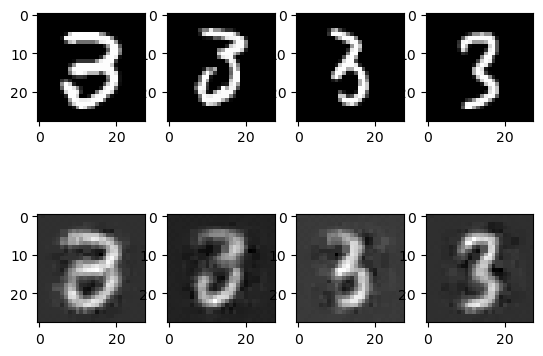

In [23]:
plot_digit(3,4)

## Deep CNN for MNIST Digit Classification

Now that we have these powerful Convolutional Layers, we want to revisit the MNIST Digit Classification task.

Previously, we were able to achieve ~96% accuracy with our one dimensional classifier. Now we will introduce convolutional layers and see how well our model performs.



### Dataset Preparation and Module Import

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [24]:
# These transforms will be performed on every datapoint - in this example we want to transform every
# datapoint to a Tensor datatype, and perform normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist_train = torchvision.datasets.MNIST('', train=True, transform =transform, download=True)

# We will split out train dataset into train and validation!
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [int(np.floor(len(mnist_train)*0.75)), int(np.ceil(len(mnist_train)*0.25))])

mnist_test = torchvision.datasets.MNIST('', train=False, transform = transform, download=True)

In [25]:
# We will create DataLoaders just like before with a batch size of 100
batch_size = 100
dataloaders = {'train': DataLoader(mnist_train, batch_size=batch_size),
               'val': DataLoader(mnist_val, batch_size=batch_size),
               'test': DataLoader(mnist_test, batch_size=batch_size)}

dataset_sizes = {'train': len(mnist_train),
                 'val': len(mnist_val),
                 'test': len(mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 45000, 'val': 15000, 'test': 10000}


### Model Hyperparameters and Definition

For our CNN Model, we will first perform a convolution and then a max pooling operation to learn 2D features in our dataset. Next we will perform a flattening and include two layers for classification to get down to our 10 different classes.

Most CNNs follow this exact pattern, where the beginning of the network performs spatial feature extraction, and then end of the network contains linear layers for classification.

In [26]:
from torch.nn.modules.flatten import Flatten
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        # Split the Encoder and Decoder

        self.pipeline = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten(),
            nn.Linear(8*14*14, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.pipeline(x)


In [27]:
learning_rate = 0.001
num_epochs = 10

model = CNNClassifier().to(device)
print(model)

CNNClassifier(
  (pipeline): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=1568, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


### Training the Model



In [28]:
# From https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # No need to flatten the inputs!
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (bas
            if phase == 'val' and epoch_acc > best_acc:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves



In [29]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
model, training_curves = train_classification_model(model, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.3641 Acc: 0.9061
val   Loss: 0.1469 Acc: 0.9579
test  Loss: 0.1304 Acc: 0.9607

Epoch 2/10
----------
train Loss: 0.1099 Acc: 0.9674
val   Loss: 0.1038 Acc: 0.9698
test  Loss: 0.0890 Acc: 0.9723

Epoch 3/10
----------
train Loss: 0.0779 Acc: 0.9773
val   Loss: 0.0879 Acc: 0.9738
test  Loss: 0.0742 Acc: 0.9765

Epoch 4/10
----------
train Loss: 0.0607 Acc: 0.9825
val   Loss: 0.0779 Acc: 0.9768
test  Loss: 0.0665 Acc: 0.9784

Epoch 5/10
----------
train Loss: 0.0497 Acc: 0.9860
val   Loss: 0.0718 Acc: 0.9789
test  Loss: 0.0621 Acc: 0.9795

Epoch 6/10
----------
train Loss: 0.0419 Acc: 0.9881
val   Loss: 0.0687 Acc: 0.9799
test  Loss: 0.0598 Acc: 0.9801

Epoch 7/10
----------
train Loss: 0.0357 Acc: 0.9904
val   Loss: 0.0665 Acc: 0.9811
test  Loss: 0.0587 Acc: 0.9813

Epoch 8/10
----------
train Loss: 0.0309 Acc: 0.9919
val   Loss: 0.0656 Acc: 0.9809
test  Loss: 0.0573 Acc: 0.9821

Epoch 9/10
----------
train Loss: 0.0268 Acc: 0.9931
val   Loss: 0.0670

Once our model has finished training we can see that just by including one set of Convolutional layers we have improved our accuracy compared to our previous 1D MLP. This is a great improvement for such a simple CNN implementation and by adding more convolutional layers and techniques the performance can be improved even further.

### Visualizing Training Curves and Results

Here we have included functions for examining the training curves and confusion matrix. Notice how the confusion matrix contains less missclassified entries than before.

In [30]:
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


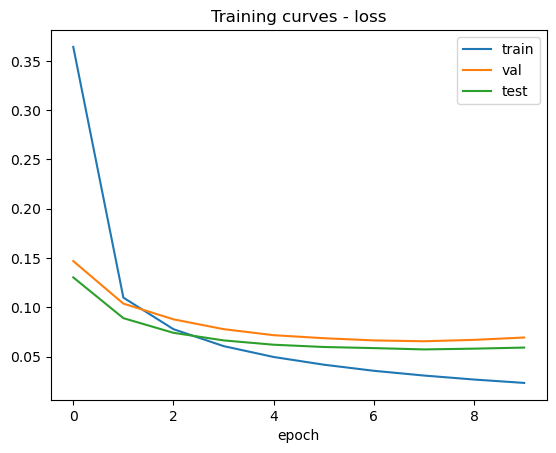

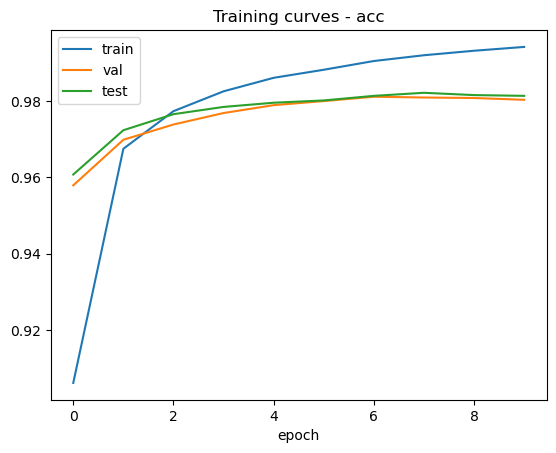

In [31]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

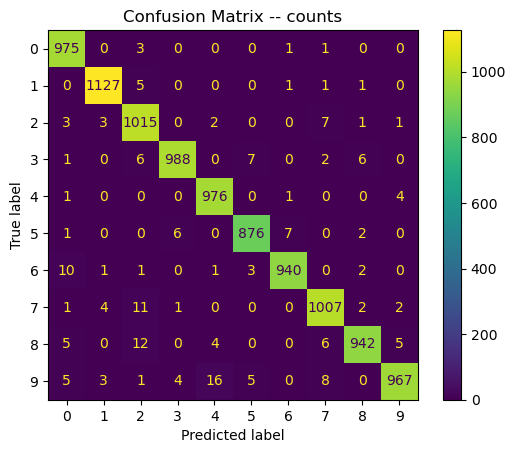

In [32]:
res = plot_cm(model, device, dataloaders, phase='test')

## Looking Ahead

Now that we have introduced 2d Convolutions, we are able to build much more complex neural networks. In the next assignment, you will be tasked with building upon our single convolutional layer network here by writing a model with at least 2 convolutional layers for classification of a brand new dataset!